In [27]:
# Test align_single_exposures
# Case 1: toy example
# Case 2: sdss data

import numpy as np
import galsim
import torch
import torch.nn.functional as F
from bliss.models.decoder import get_mgrid
from bliss.datasets.galsim_galaxies import GalsimBlends
import matplotlib.pyplot as plt
from hydra import compose, initialize
from hydra.utils import instantiate
from torch import Tensor
from typing import Dict, Optional
import pytorch_lightning as pl
from einops import rearrange
from torch.utils.data import DataLoader, Dataset
from bliss.catalog import TileCatalog, get_is_on_from_n_sources, FullCatalog
from bliss.datasets.background import ConstantBackground
from bliss.datasets.sdss import convert_flux_to_mag
from bliss.models.galsim_decoder import SingleGalsimGalaxyDecoder,SingleGalsimGalaxyPrior,UniformGalsimGalaxiesPrior

from case_studies.coadds.signal_noise_ratio  import snr


In [71]:
def align_single_exposures(img0, img1, slen, dithers, scale = 0.393):
    """Aligns multiple single exposure images that are dithered by some sub-pixel amount.
    Args:
        img0: Galsim image object
        img1: Tensor of shape `(N x C x H x W)` where N is the number of dithers (len(dithers)), 
            C is the number of band, H is height and W is weight, containing image data.
        slen: size of images (H and W)
        dithers: List of pairs of sub-pixel amounts that img0 is shifted by in x and y directions
        scale: pixel_scale
    Returns:
        Tensor of shape `(N x H-2 x W-2)`. Aligned images with 1 pixel cropped from from each 
            direction of height and width.
    """
    img0 = galsim.Image(np.array(img0), wcs=galsim.PixelScale(scale)) 
    wcs0 = img0.wcs
    images = img1

    sgrid = (get_mgrid(slen) - (-1))/2 * (slen)
    sgrid = sgrid.reshape(slen**2,2)
    grid_x = wcs0.xyTouv(sgrid[:,0],sgrid[:,1])[0]
    grid_y = wcs0.xyTouv(sgrid[:,0],sgrid[:,1])[1]

    grid = torch.empty(size=(0, 2))
    for i in dithers:
        wcs1 = galsim.OffsetWCS(scale = scale, origin = galsim.PositionD(i))
        x, y = wcs1.uvToxy(grid_x,grid_y)
        x_grid = (x/slen) * 2 + (-1)
        y_grid = (y/slen) * 2 + (-1)
        grid = torch.cat([grid, torch.stack((torch.tensor(x_grid),torch.tensor(y_grid)),-1)], dim=0)

    iplots = []
    input = torch.tensor(images[:]).reshape(len(dithers),1,slen,slen).float()
    grids = grid.reshape(len(dithers),1,slen*slen,2).float()
    iplots.append(F.grid_sample(input, grids, align_corners = False))

    # reshape and crop 1 pixel on each side
    iplots = torch.tensor(iplots[:][0]).reshape(len(dithers),slen,slen)
    iplots_cropped = iplots[:,1:slen-1,1:slen-1]
    return iplots_cropped

In [45]:
def render_galaxy(
        self,
        galaxy_params: Tensor,
        psf: galsim.GSObject,
        slen: int,
        offset: Optional[Tensor] = None,
        dithers: Optional[Tensor] = None,
    ) -> Tensor:
        assert offset is None or offset.shape == (2,)
        if isinstance(galaxy_params, Tensor):
            galaxy_params = galaxy_params.cpu().detach()
        total_flux, disk_frac, beta_radians, disk_q, a_d, bulge_q, a_b = galaxy_params
        bulge_frac = 1 - disk_frac

        disk_flux = total_flux * disk_frac
        bulge_flux = total_flux * bulge_frac

        components = []
        if disk_flux > 0:
            b_d = a_d * disk_q
            disk_hlr_arcsecs = np.sqrt(a_d * b_d)
            disk = galsim.Exponential(flux=disk_flux, half_light_radius=disk_hlr_arcsecs).shear(
                q=disk_q,
                beta=beta_radians * galsim.radians,
            )
            components.append(disk)
        if bulge_flux > 0:
            b_b = bulge_q * a_b
            bulge_hlr_arcsecs = np.sqrt(a_b * b_b)
            bulge = galsim.DeVaucouleurs(
                flux=bulge_flux, half_light_radius=bulge_hlr_arcsecs
            ).shear(q=bulge_q, beta=beta_radians * galsim.radians)
            components.append(bulge)
        galaxy = galsim.Add(components)
        gal_conv = galsim.Convolution(galaxy, psf)
        offset = (0,0) if offset is None else offset
        dithers = (0,0) if dithers is None else dithers
        shift = torch.add(torch.Tensor(dithers), torch.Tensor(offset))
        shift = shift.reshape(1,2) if len(shift) == 2 else shift
        images = []
        for i in shift:
            image = gal_conv.drawImage(
                nx=slen, ny=slen, method="auto", scale=self.pixel_scale, offset=i
            )
            image = image.array
            images.append(image)
        return torch.tensor(images[:]).reshape(len(shift), 1, slen, slen)

In [67]:
%load_ext autoreload
%autoreload 2
%aimport
%matplotlib inline 

Modules to reload:
all-except-skipped

Modules to skip:



In [ ]:
# Case 1: toy example

In [30]:
# Create initial image I0
pixel_scale = 0.393 
slen = 10

# create base wcs
g0 = galsim.Gaussian(sigma=1.0)
g0 = g0.shear(e1=0, e2=0)
img0 = g0.drawImage(nx=slen, ny=slen, scale=pixel_scale)

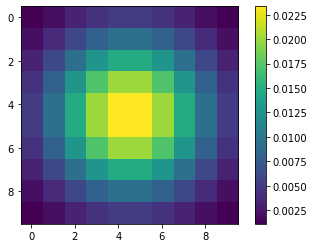

In [4]:
img0 = img0.array
plt.figure()
plt.imshow(img0)
plt.colorbar()

In [45]:
# this seems silly but is the way the function expects img0 outputted from render_catalog
img0 = torch.tensor(img0.array)

torch.Size([10, 10])

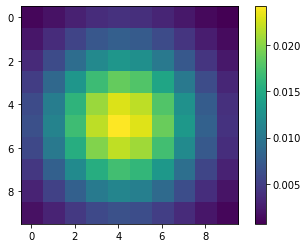

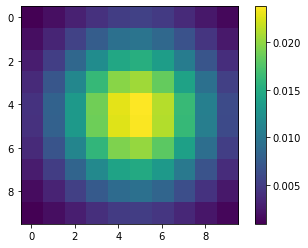

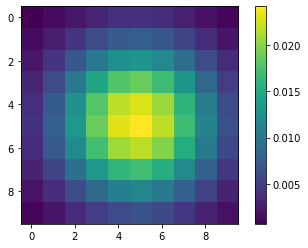

In [8]:
# create dithers
n = 3
dithers = [((-0.5 - 0.5) * torch.rand((2,)) + 0.5).numpy() for x in range(n)]

# this is the same code as from render_galaxy (minus the plots)
images = []
for i in dithers:
    image = g0.drawImage(nx=slen, ny=slen, method="auto", scale=pixel_scale, offset = i)
    image = image.array

    plt.figure()
    plt.imshow(image)
    plt.colorbar()

    images.append(image)
images = torch.tensor(images[:]).reshape(len(dithers),1, slen, slen)

In [49]:
aligned_images = align_single_exposures(img0, images, slen, dithers)
aligned_images.shape

/tmp/ipykernel_3396846/2051988343.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.cat([grid, torch.stack((torch.tensor(x_grid),torch.tensor(y_grid)),-1)], dim=0)
/tmp/ipykernel_3396846/2051988343.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images[:]).reshape(len(dithers),1,slen,slen).float()
/tmp/ipykernel_3396846/2051988343.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  iplots = torch.tensor(iplots[:][0]).reshape(len(dithers),slen,slen)


torch.Size([3, 8, 8])

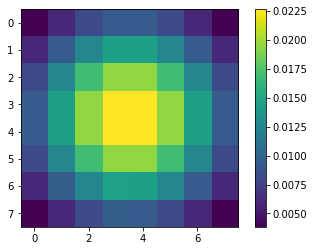

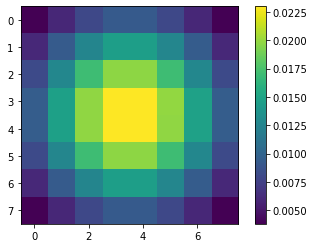

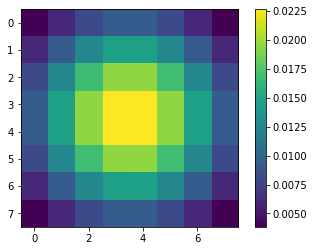

In [51]:
for i in range(len(dithers)):
    plt.figure()
    plt.imshow(aligned_images[i])
    plt.colorbar()

In [ ]:
# Case 2: sdss data

In [4]:
with initialize(config_path="../sdss_galaxies/config"):
    cfg = compose("config", overrides=[])

In [60]:
decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)
psf = decoder.psf
prior = instantiate(cfg.datasets.galsim_blended_galaxies.prior) 
decoder = instantiate(cfg.datasets.galsim_blended_galaxies.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 1000
n_batches = 1
full_catalog = GalsimBlends(prior = prior, decoder = decoder, background = background, tile_slen = tile_slen, max_sources_per_tile = max_tile_n_sources, num_workers = num_workers, batch_size = batch_size, n_batches = n_batches)._sample_full_catalog()

In [62]:
size = decoder.slen + 2 * decoder.bp
full_plocs = full_catalog.plocs
b, max_n_sources, _ = full_plocs.shape

image = torch.zeros(len(dithers), 1, size, size)
image0 = torch.zeros(1, 1, size, size)
noiseless_centered = torch.zeros(len(dithers), max_n_sources, 1, size, size)
noiseless_uncentered = torch.zeros(len(dithers), max_n_sources, 1, size, size)

n_sources = int(full_catalog.n_sources[0].item())
galaxy_params = full_catalog["galaxy_params"][0]

offset_x = plocs[0][1] + decoder.bp - size / 2
offset_y = plocs[0][0] + decoder.bp - size / 2
offset = torch.tensor([offset_x, offset_y])
decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)
uncentered = render_galaxy(decoder, galaxy_params[0], psf, size, offset)
uncentered_dithered = render_galaxy(decoder, galaxy_params[0], psf, size, offset, dithers)

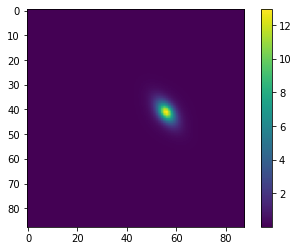

In [68]:
plt.figure()
plt.imshow(uncentered.reshape(size,size))
plt.colorbar()

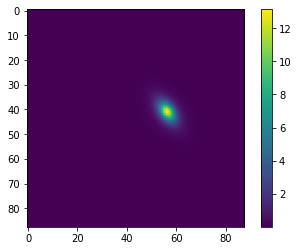

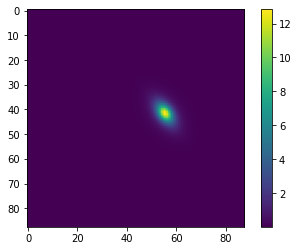

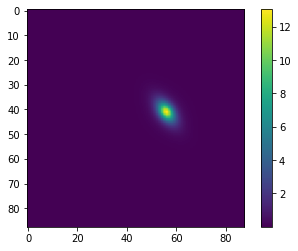

In [69]:
# hard to tell the dithers
for i in range(len(dithers)):
    plt.figure()
    plt.imshow(uncentered_dithered.reshape(len(dithers),size,size)[i])
    plt.colorbar()

In [75]:
# now the data is like the output from render_catalog with only one source
img0 = uncentered.reshape(size,size)
images = uncentered_dithered


In [76]:
aligned_images = align_single_exposures(img0, images, size, dithers)
aligned_images.shape # the output should be cropped

/tmp/ipykernel_3405401/2051988343.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.cat([grid, torch.stack((torch.tensor(x_grid),torch.tensor(y_grid)),-1)], dim=0)
/tmp/ipykernel_3405401/2051988343.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(images[:]).reshape(len(dithers),1,slen,slen).float()
/tmp/ipykernel_3405401/2051988343.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  iplots = torch.tensor(iplots[:][0]).reshape(len(dithers),slen,slen)


torch.Size([3, 86, 86])

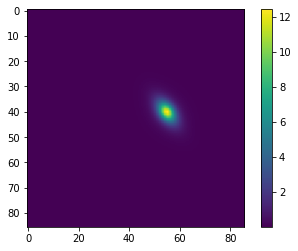

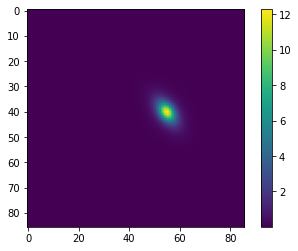

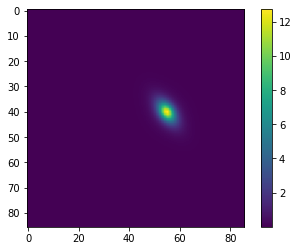

In [77]:
# still hard to tell the dithers
for i in range(len(dithers)):
    plt.figure()
    plt.imshow(aligned_images[i])
    plt.colorbar()